In [1]:
%matplotlib inline


# Decoding sensor space data with generalization across time and conditions


This example runs the analysis described in [1]_. It illustrates how one can
fit a linear classifier to identify a discriminatory topography at a given time
instant and subsequently assess whether this linear model can accurately
predict all of the time samples of a second set of conditions.

References
----------

.. [1] King & Dehaene (2014) 'Characterizing the dynamics of mental
       representations: the Temporal Generalization method', Trends In
       Cognitive Sciences, 18(4), 203-210. doi: 10.1016/j.tics.2014.01.002.



Automatically created module for IPython interactive environment
Successfully extracted to: ['/home/karim/mne_data/MNE-sample-data']
Opening raw data file /home/karim/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Setting up band-pass filter from 1 - 30 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 496 samples (3.303 sec) selected
288 matching events found
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 288 events and 69 original time points ...
    Rejecting  epoch based on MAG : ['MEG 1711']
1 bad epochs dropped


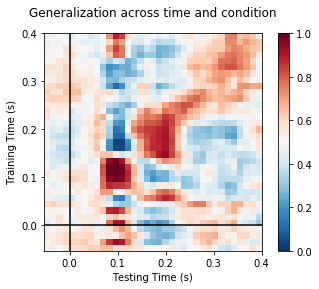

In [2]:
# Authors: Jean-Remi King <jeanremi.king@gmail.com>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Denis Engemann <denis.engemann@gmail.com>
#
# License: BSD (3-clause)

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator

print(__doc__)

# Preprocess data
data_path = sample.data_path()
# Load and filter data, set up epochs
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
events_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)
picks = mne.pick_types(raw.info, meg=True, exclude='bads')  # Pick MEG channels
raw.filter(1., 30., fir_design='firwin')  # Band pass filtering signals
events = mne.read_events(events_fname)
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4}
tmin = -0.050
tmax = 0.400
decim = 2  # decimate to make the example faster to run
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    proj=True, picks=picks, baseline=None, preload=True,
                    reject=dict(mag=5e-12), decim=decim)

# We will train the classifier on all left visual vs auditory trials
# and test on all right visual vs auditory trials.
clf = make_pipeline(StandardScaler(), LogisticRegression())
time_gen = GeneralizingEstimator(clf, scoring='roc_auc', n_jobs=1)

# Fit classifiers on the epochs where the stimulus was presented to the left.
# Note that the experimental condition y indicates auditory or visual
time_gen.fit(X=epochs['Left'].get_data(),
             y=epochs['Left'].events[:, 2] > 2)

# Score on the epochs where the stimulus was presented to the right.
scores = time_gen.score(X=epochs['Right'].get_data(),
                        y=epochs['Right'].events[:, 2] > 2)

# Plot
fig, ax = plt.subplots(1)
im = ax.matshow(scores, vmin=0, vmax=1., cmap='RdBu_r', origin='lower',
                extent=epochs.times[[0, -1, 0, -1]])
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Generalization across time and condition')
plt.colorbar(im, ax=ax)
plt.show()